# Generating Images to Fool an MNIST Classifier

Despite their high performance on classification tasks suh as MNIST, neural networks like the [LeNet-5](https://en.wikipedia.org/wiki/LeNet) have a weakness: they are easy to fool. Namely, given images like the ones below, a classifier may confidently believe that it is seeing certain digits, even though the images look like random noise to humans. Naturally, this phenomenon raises some concerns, especially when the network in question is used in a safety-critical system like a self-driving car. Given such unrecognizable input, one would hope that the network at least has low confidence in its prediction.

![fooling images example](_static/fooling_mnist_example.png)

To make matters worse for neural networks, generating such images is incredibly easy with QD algorithms. As shown in [Nguyen 2015](http://anhnguyen.me/project/fooling/), one can use simple MAP-Elites to generate these images. In this tutorial, we will use the pyribs version of MAP-Elites to do exactly that.

## Setup

In [ ]:
%pip install ribs torch torchvision

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

from ribs.archives import GridArchive
from ribs.emitters import GaussianEmitter
from ribs.optimizers import Optimizer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Preliminary: MNIST Network

For our classifier network, we train a LeNet-5 to classify MNIST. If you are not familiar with PyTorch, we recommend referring to the [PyTorch 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). On the other hand, if you are familiar, feel free to skip to the next section, where we demonstrate how to fool the network.

Before the training the network, we load and preprocess the MNIST dataset.

In [4]:
# Transform each image by turning it into a tensor and then
# normalizing the values.
MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAIN_BATCH_SIZE = 64
TRAINLOADER = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=mnist_transforms),
                                          batch_size=TRAIN_BATCH_SIZE,
                                          shuffle=True)

TEST_BATCH_SIZE = 1000
TESTLOADER = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    './data', train=False, transform=mnist_transforms),
                                         batch_size=TEST_BATCH_SIZE,
                                         shuffle=False)

This is our training function. We use negative log likelihood loss and Adam optimization.

In [5]:
def fit(net, epochs):
    """Trains net for the given number of epochs."""
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        print(f"=== Epoch {epoch + 1} ===")
        total_loss = 0.0

        # Iterate through batches in the shuffled training dataset.
        for batch_i, data in enumerate(TRAINLOADER):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_i + 1) % 100 == 0:
                print(f"Batch {batch_i + 1:5d}: {total_loss}")
                total_loss = 0.0

Now, we define the LeNet-5 and train it for 2 epochs. We have annotated the shapes of the data (excluding the batch dimension) as they pass through the network.

In [6]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)

fit(LENET5, 2)

=== Epoch 1 ===
Batch   100: 104.05875018239021
Batch   200: 32.66764344274998
Batch   300: 22.60749428719282
Batch   400: 14.98543407395482
Batch   500: 12.60848225839436
Batch   600: 11.927413458004594
Batch   700: 11.24536281824112
Batch   800: 10.417082185856998
Batch   900: 9.445754482410848
=== Epoch 2 ===
Batch   100: 8.67462042812258
Batch   200: 6.596098876558244
Batch   300: 8.126990044489503
Batch   400: 6.144526142627001
Batch   500: 6.19329902343452
Batch   600: 6.277753548230976
Batch   700: 6.5695476308465
Batch   800: 7.3804698921740055
Batch   900: 6.067771065048873


Finally, we evaluate the network on the train and test sets.

In [7]:
def evaluate(net, loader):
    """Evaluates the network's accuracy on the images in the dataloader."""
    correct_per_num = [0 for _ in range(10)]
    total_per_num = [0 for _ in range(10)]

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.to("cpu"), 1)
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                correct_per_num[label] += c[i].item()
                total_per_num[label] += 1

    for i in range(10):
        print(f"Class {i}: {correct_per_num[i] / total_per_num[i]:5.3f}"
              f" ({correct_per_num[i]} / {total_per_num[i]})")
    print(f"TOTAL  : {sum(correct_per_num) / sum(total_per_num):5.3f}"
          f" ({sum(correct_per_num)} / {sum(total_per_num)})")

In [8]:
evaluate(LENET5, TRAINLOADER)

Class 0: 0.997 (5905 / 5923)
Class 1: 0.999 (6735 / 6742)
Class 2: 0.977 (5822 / 5958)
Class 3: 0.953 (5843 / 6131)
Class 4: 0.983 (5740 / 5842)
Class 5: 0.985 (5339 / 5421)
Class 6: 0.992 (5869 / 5918)
Class 7: 0.980 (6141 / 6265)
Class 8: 0.982 (5748 / 5851)
Class 9: 0.981 (5835 / 5949)
TOTAL  : 0.983 (58977 / 60000)


In [9]:
evaluate(LENET5, TESTLOADER)

Class 0: 0.995 (975 / 980)
Class 1: 0.998 (1133 / 1135)
Class 2: 0.980 (1011 / 1032)
Class 3: 0.953 (963 / 1010)
Class 4: 0.989 (971 / 982)
Class 5: 0.989 (882 / 892)
Class 6: 0.981 (940 / 958)
Class 7: 0.976 (1003 / 1028)
Class 8: 0.985 (959 / 974)
Class 9: 0.970 (979 / 1009)
TOTAL  : 0.982 (9816 / 10000)


## Fooling the Classifier with MAP-Elites

Above, we trained a reasonably high-performing classifier. In order to fool the classifier into seeing various digits, we use MAP-Elites. As we have 10 distinct digits (0-9), we have a discrete behavior space with 10 values. Above, our classifier outputs a log probability vector with its belief that it is seeing each digit. Thus, our objective for each digit is to maximize the probability that the classifier assigns to the image associated with it. For instance, for digit 5, we want to generate an image that makes the classifier believe with high probability that it is seeing a 5.

In pyribs, we implement MAP-Elites with a `GridArchive` and a `GaussianEmitter`. Below, we start by constructing the `GridArchive`. The archive has 10 bins and a range of (0,10). Since `GridArchive` was originally designed for continuous spaces, it does not directly support discrete spaces, but by using these settings, we have a bin for each digit from 0 to 9.

In [10]:
archive = GridArchive([10], [(0, 10)])

Next, the `GaussianEmitter` begins with an image filled with 0.5 (i.e. grey, since pixels are in the range (0,1)) and generates random images by adding Gaussian noise with standard deviation 0.5. After the first iteration, the emitter adds the Gaussian noise to random elites in the archive.

In [11]:
img_size = (28, 28)
flat_img_size = 784  # 28 * 28
emitters = [
    GaussianEmitter(
        archive,
        # Start with a grey image.
        np.full(flat_img_size, 0.5),
        # 0.5 standard deviation to cover the whole range of images.
        0.5,
        # Bound the generated images to the pixel range of the images.
        bounds=[(0, 1)] * flat_img_size,
        batch_size=64,
    )
]

Finally, we construct the optimizer to connect the archive and emitters together.

In [12]:
optimizer = Optimizer(archive, emitters)

With the components created, we now generate the images. As the emitter has batch size 64 and we run 15,000 iterations, we evaluate 960,000 images in total.

In [13]:
total_itrs = 15_000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask()

    with torch.no_grad():

        # Reshape and normalize the image and pass it through the network.
        imgs = sols.reshape((-1, 1, *img_size))
        imgs = (imgs - MEAN_TRANSFORM) / STD_DEV_TRANSFORM
        imgs = torch.tensor(imgs, dtype=torch.float32, device=device)
        output = LENET5(imgs)

        # The BC is the digit that the network believes it is seeing, i.e. the
        # digit with the maximum probability. The objective is the probability
        # associated with that digit.
        scores, predicted = torch.max(output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        bcs = predicted.numpy()

    optimizer.tell(objs, bcs)

    if itr % 1000 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

Iteration 1000 complete after 6.583799839019775 s
Iteration 2000 complete after 13.378127098083496 s
Iteration 3000 complete after 19.498377323150635 s
Iteration 4000 complete after 24.7131507396698 s
Iteration 5000 complete after 30.050055503845215 s
Iteration 6000 complete after 34.987005949020386 s
Iteration 7000 complete after 42.060264348983765 s
Iteration 8000 complete after 48.691709756851196 s
Iteration 9000 complete after 55.84390568733215 s
Iteration 10000 complete after 63.679113149642944 s
Iteration 11000 complete after 69.51899433135986 s
Iteration 12000 complete after 76.88922810554504 s
Iteration 13000 complete after 84.6748218536377 s
Iteration 14000 complete after 93.00445079803467 s
Iteration 15000 complete after 99.50167036056519 s


Below, we display the results we found with MAP-Elites. The `index_0` column shows the digit associated with each image, and the `objective` column shows the network's belief that the image is that digit. The `solution` columns show the image's pixel values.

In [14]:
archive.as_pandas().sort_values("index_0")

,index_0,behavior_0,objective,solution_0,solution_1,solution_2,solution_3,solution_4,solution_5,solution_6,...,solution_774,solution_775,solution_776,solution_777,solution_778,solution_779,solution_780,solution_781,solution_782,solution_783
3,0,0.0,0.974767,0.438514,0.137440,1.000000,0.091439,0.323721,0.595538,0.541427,...,0.000000,0.017290,1.000000,0.640506,0.000000,0.399020,0.294919,0.000000,0.277442,1.000000
4,1,1.0,0.874809,1.000000,0.000000,0.462769,0.736841,0.413149,1.000000,0.032153,...,0.000000,0.477436,0.163252,0.634795,0.604286,0.046643,1.000000,1.000000,0.107447,0.376860
2,2,2.0,0.989309,0.567776,1.000000,0.276714,0.000000,0.858094,1.000000,0.000000,...,1.000000,0.408137,0.552990,0.166472,0.413101,0.000000,0.287672,1.000000,0.920290,0.336544
1,3,3.0,0.993900,1.000000,0.217978,0.554727,0.767231,0.000000,0.000000,0.262807,...,0.000000,0.069533,0.049343,0.690000,0.000000,0.175842,0.337845,0.429926,1.000000,0.618268
8,4,4.0,0.950847,0.504189,0.600669,1.000000,0.792341,1.000000,1.000000,1.000000,...,0.000000,0.374392,0.000000,0.000000,0.580114,0.173094,1.000000,0.175546,1.000000,1.000000
6,5,5.0,0.994286,0.000515,0.168286,0.000000,0.204953,0.072450,0.000000,1.000000,...,1.000000,0.231357,0.654818,0.000000,0.674185,0.646424,0.587912,0.119216,1.000000,0.483821
9,6,6.0,0.922751,0.000000,0.514078,0.000000,0.472218,1.000000,1.000000,0.422203,...,1.000000,1.000000,0.000000,1.000000,0.834119,1.000000,0.017994,1.000000,0.425199,0.605551
7,7,7.0,0.942844,0.000000,0.854834,0.000000,0.477746,0.843315,0.497624,0.000000,...,0.587237,0.000000,1.000000,0.126746,0.000000,0.000000,0.232047,0.050801,0.847697,1.000000
0,8,8.0,0.998382,0.651196,0.230279,0.000000,0.693062,0.260174,1.000000,0.000000,...,0.000000,0.253260,0.906332,0.436550,0.323638,0.850188,0.243665,1.000000,0.271453,0.468901
5,9,9.0,0.783577,0.000000,1.000000,1.000000,0.566808,0.027275,1.000000,0.000000,...,0.372171,0.449304,0.000000,0.000000,0.000000,1.000000,0.300654,0.000000,1.000000,0.000000


Here, we display the images found by the network. Interestingly, though the images look mostly like noise, we can occasionally make out traces of the original digit. Note that MAP-Elites may not find images for all the digits. If this is the case, consider re-running the algorithm and increasing the number of iterations.

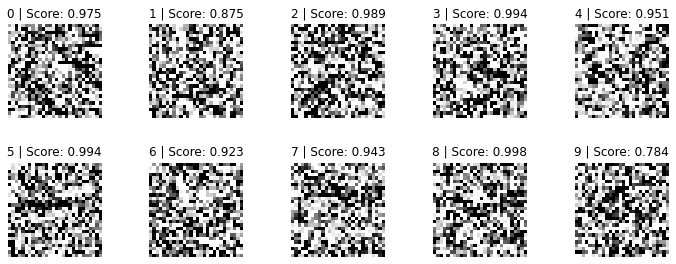

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()

# Display images.
for _, row in archive.as_pandas().iterrows():
    i = int(row.loc["index_0"])
    found.add(i)
    obj = row.loc["objective"]
    ax[i].set_title(f"{i} | Score: {obj:.3f}", pad=8)
    img = row.loc["solution_0":].to_numpy().reshape(28, 28)

    # No need to normalize image because we want to see the original.
    ax[i].imshow(img, cmap="Greys")
    ax[i].set_axis_off()

# Mark digits that we did not generate images for.
for i in range(10):
    if i not in found:
        ax[i].set_title(f"{i} | (no solution)", pad=8)
        ax[i].set_axis_off()

## Conclusion

In this tutorial, we used MAP-Elites to generate images that fool a LeNet-5 MNIST classifier. For further exploration, we recommend referring to [Nguyen 2015](http://anhnguyen.me/project/fooling/) and replicating or extending the other experiments described in the paper.